DeepLarning Couse MSU 2016 fall: 
* Arseniy Ashuha, you can text me ```ars.ashuha@gmail.com```, Александр Панин ```jheuristic@yandex-team.ru```
* ```https://vk.com/ars.ashuha```

<h1 align="center"> Image Captioning </h1> 

In this seminar you'll be going through the image captioning pipeline.

To begin with, let us download the dataset of image features from a pre-trained GoogleNet.



In [1]:
!wget https://www.dropbox.com/s/3hj16b0fj6yw7cc/data.tar.gz?dl=1 -O data.tar.gz
!tar -xvzf data.tar.gz

--2017-04-07 02:49:49--  https://www.dropbox.com/s/3hj16b0fj6yw7cc/data.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.1
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/content_link/EH0GttKHRM33HLfK8RGwUIegtaxssoXQGeqU6cJjO16vaPvVkFrStEPi1j7ooGF7/file?dl=1 [following]
--2017-04-07 02:49:50--  https://dl.dropboxusercontent.com/content_link/EH0GttKHRM33HLfK8RGwUIegtaxssoXQGeqU6cJjO16vaPvVkFrStEPi1j7ooGF7/file?dl=1
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.66.6
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.66.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 506221998 (483M) [application/octet-stream]
Saving to: ‘data.tar.gz’

data.tar.gz         100%[===================>] 482,77M   772KB/s    in 11m 38s 

2017-04-07 03:01:30 (708 KB/s) - ‘data.tar.gz’ sa

### Data preprocessing

In [51]:
%%time
# Read Dataset
import numpy as np
import pickle

img_codes = np.load("data/image_codes.npy")
captions = pickle.load(open('data/caption_tokens.pcl', 'rb'))

CPU times: user 2.25 s, sys: 244 ms, total: 2.5 s
Wall time: 2.51 s


In [52]:
print "each image code is a 1000-unit vector:", img_codes.shape
print img_codes[0,:10]
print '\n\n'
print "for each image there are 5-7 descriptions, e.g.:\n"
print '\n'.join(captions[0])

each image code is a 1000-unit vector: (123287, 1000)
[ 1.38901556 -3.82951474 -1.94360816 -0.5317238  -0.03120959 -2.87483215
 -2.9554503   0.6960277  -0.68551242 -0.7855981 ]



for each image there are 5-7 descriptions, e.g.:

a man with a red helmet on a small moped on a dirt road
man riding a motor bike on a dirt road on the countryside
a man riding on the back of a motorcycle
a dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud wreathed mountains
a man in a red shirt and a red hat is on a motorcycle on a hill side


In [53]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]

In [54]:
# Build a Vocabulary

############# TO CODE IT BY YOURSELF ##################
#word_counts = <here should be dict word:number of entrances>
from collections import Counter
word_counts = Counter()
for img_captions in captions:
    for caption in img_captions:
        word_counts.update(caption)




vocab  = ['#UNK#', '#START#', '#END#']
vocab += [k for k, v in word_counts.items() if v >= 5]
n_tokens = len(vocab)
assert 10000 <= n_tokens <= 10500
word_to_index = {w: i for i, w in enumerate(vocab)}

In [55]:
PAD_ix = -1
UNK_ix = vocab.index('#UNK#')

def as_matrix(sequences,max_len=None):
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences),max_len),dtype='int32')+PAD_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word,UNK_ix) for word in seq[:max_len]]
        matrix[i,:len(row_ix)] = row_ix
    
    return matrix

In [56]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[ 8481,  2852,  7829,  4136, 10058,  9934,  5915,  4859,  6766,
         1243,  3980,  6254,  8134,    -1,    -1],
       [ 8481,  6766,  1243,  8902,  1021,  9095,  6254,  3980,  8256,
          727,  5915,  8134,    -1,    -1,    -1],
       [ 8481,  8717,  4136, 10058,  9934,  5915,  4859,  6766,  5627,
         8639,   535,  5470,  7115,  5155,  8134],
       [ 8481,  8717,  8897,  3069,  2538,   781,  8717,  8897,  1558,
         8134,    -1,    -1,    -1,    -1,    -1],
       [ 8481,  2852,  7829,  4136, 10058,  9934,  5915,  4859,  6766,
         1243,   535,  5470,  8919,  8134,    -1]], dtype=int32)

### Mah Neural Network

In [57]:
# network shapes. 
CNN_FEATURE_SIZE = img_codes.shape[1]
EMBED_SIZE = 256 #128 #pls change me if u want
LSTM_UNITS = 400 #200 #pls change me if u want

In [58]:
import theano
import lasagne
import theano.tensor as T
from lasagne.layers import *

In [59]:
# Input Variable
sentences = T.imatrix()# [batch_size x time] of word ids
image_vectors = T.matrix() # [batch size x unit] of CNN image features
sentence_mask = T.neq(sentences, PAD_ix)

In [60]:
#network inputs
l_words = InputLayer((None, None), sentences)
l_mask = InputLayer((None, None), sentence_mask)

#embeddings for words 
############# TO CODE IT BY YOURSELF ##################
#l_word_embeddings = <Embedding Layer>

l_word_embeddings = EmbeddingLayer(l_words,n_tokens,EMBED_SIZE)


In [61]:
# input layer for image features
l_image_features = InputLayer((None, CNN_FEATURE_SIZE), image_vectors)

############# TO CODE IT BY YOURSELF ##################
#convert 1000 image features from googlenet to whatever LSTM_UNITS you have set
#it's also a good idea to add some dropout here and there
#l_image_features_small = <Apply Dropout Layer to regularise your Net>
#l_image_features_small = <Apply Dense to acive LSTM_UNITS size of representation>

l_image_features_small = DropoutLayer(l_image_features,0.5)
l_image_features_small = DenseLayer(l_image_features_small, LSTM_UNITS)



assert l_image_features_small.output_shape == (None, LSTM_UNITS)

In [62]:
############# TO CODE IT BY YOURSELF ##################
# Concatinate image features and word embedings in one sequence 
#decoder = LSTMLayer(<Hmmm, what whould be here?>,
#                    num_units=LSTM_UNITS,
#                    cell_init=<Use your brain =)>,
#                    mask_input=<Mask?>,
#                    grad_clipping=<boom grads>)
        
decoder = LSTMLayer(l_word_embeddings,
                    num_units=LSTM_UNITS,
                    cell_init=l_image_features_small,
                    mask_input=l_mask,
                    grad_clipping=5)   
                

In [63]:
# Decoding of rnn hiden states
from broadcast import BroadcastLayer,UnbroadcastLayer

#apply whatever comes next to each tick of each example in a batch. Equivalent to 2 reshapes
broadcast_decoder_ticks = BroadcastLayer(decoder, (0, 1))
print "broadcasted decoder shape = ",broadcast_decoder_ticks.output_shape

predicted_probabilities_each_tick = DenseLayer(
    broadcast_decoder_ticks,n_tokens, nonlinearity=lasagne.nonlinearities.softmax)

#un-broadcast back into (batch,tick,probabilities)
predicted_probabilities = UnbroadcastLayer(
    predicted_probabilities_each_tick, broadcast_layer=broadcast_decoder_ticks)

print "output shape = ", predicted_probabilities.output_shape

#remove if you know what you're doing (e.g. 1d convolutions or fixed shape)
assert predicted_probabilities.output_shape == (None, None, 10373)

broadcasted decoder shape =  (None, 400)
output shape =  (None, None, 10373)


In [64]:
next_word_probas = get_output(predicted_probabilities)

reference_answers = sentences[:,1:]
output_mask = sentence_mask[:,1:]

#write symbolic loss function to train NN for
loss = lasagne.objectives.categorical_crossentropy(
    next_word_probas[:, :-1].reshape((-1, n_tokens)),
    reference_answers.reshape((-1,))
).reshape(reference_answers.shape)

############# TO CODE IT BY YOURSELF ##################
#loss = <mean over non-PAD tokens>

loss = (loss*output_mask).sum() / output_mask.sum()



In [98]:
#trainable NN weights
############# TO CODE IT BY YOURSELF ##################
#weights = <all dnn weigts>
#updates = <your favorite optimizer>

weights = get_all_params(predicted_probabilities,trainable=True)
#updates = lasagne.updates.adam(loss,weights)
updates = lasagne.updates.adamax(loss,weights)



In [99]:
#compile a function that takes input sentence and image mask, outputs loss and updates weights
#please not that your functions must accept image features as FIRST param and sentences as second one
############# TO CODE IT BY YOURSELF ##################
#train_step = <>
#val_step   = <>

train_step = theano.function([image_vectors,sentences],loss,updates=updates)
val_step   = theano.function([image_vectors,sentences],loss)



# Training

* You first have to implement a batch generator
* Than the network will get trained the usual way

In [100]:
captions = np.array(captions)

In [101]:
from random import choice

def generate_batch(images,captions,batch_size,max_caption_len=None):
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(images), size=batch_size)
    
    #get images
    batch_images = images[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick 1 from 5-7 captions for each image
    batch_captions = map(choice, captions_for_batch_images)
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return batch_images, batch_captions_ix

In [102]:
generate_batch(img_codes,captions, 3)

(array([[-4.70827818, -2.04740167, -2.10882092, ..., -0.80517477,
         -0.39949882, -0.95774007],
        [ 3.30782032, -1.23467219, -1.92066276, ...,  0.04335076,
          7.69077682,  3.06664324],
        [-1.02923477, -0.1584588 ,  3.64799595, ..., -1.56021547,
         -0.84774971, -0.62599576]], dtype=float32),
 array([[ 8481,  8717,  4136, 10058,  9934,  3790,  4859,     0,  9169,
          7894,  8134,    -1,    -1],
        [ 8481,  8717, 10014,   326,  3180,  8717,  3384, 10058,  4674,
          2474,  4859,  1719,  8134],
        [ 8481,  8717,  5480,  4913,  3974,  5531,  5330,  2854,  3323,
          4238,  8134,    -1,    -1]], dtype=int32))

### Main loop
* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again

In [103]:
batch_size = 50 #adjust me
n_epochs   = 100 #adjust me
n_batches_per_epoch = 50 #adjust me
n_validation_batches = 5 #how many batches are used for validation after each epoch

In [104]:
%%time

from tqdm import tqdm

for epoch in range(n_epochs):
    train_loss=0
    for _ in tqdm(range(n_batches_per_epoch)):
        train_loss += train_step(*generate_batch(img_codes,captions,batch_size))
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    for _ in range(n_validation_batches):
        val_loss += val_step(*generate_batch(img_codes,captions,batch_size))
    val_loss /= n_validation_batches
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finish :)")

  2%|▏         | 1/50 [00:00<00:08,  5.58it/s]


Epoch: 0, train loss: 2.74009891987, val loss: 2.75994477272


  2%|▏         | 1/50 [00:00<00:08,  6.04it/s]


Epoch: 1, train loss: 2.77572482586, val loss: 2.80212016106


  2%|▏         | 1/50 [00:00<00:06,  8.07it/s]


Epoch: 2, train loss: 2.73908166885, val loss: 2.77191739082


  2%|▏         | 1/50 [00:00<00:07,  6.91it/s]


Epoch: 3, train loss: 2.74197850704, val loss: 2.66481952667


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 4, train loss: 2.76046194553, val loss: 2.73282165527


  2%|▏         | 1/50 [00:00<00:09,  5.08it/s]


Epoch: 5, train loss: 2.72928387165, val loss: 2.80949497223


  2%|▏         | 1/50 [00:00<00:07,  6.76it/s]


Epoch: 6, train loss: 2.73334574223, val loss: 2.66175699234


  2%|▏         | 1/50 [00:00<00:06,  7.06it/s]


Epoch: 7, train loss: 2.73709789276, val loss: 2.67531676292


  2%|▏         | 1/50 [00:00<00:07,  6.13it/s]


Epoch: 8, train loss: 2.74655659676, val loss: 2.8350467205


  2%|▏         | 1/50 [00:00<00:06,  7.48it/s]


Epoch: 9, train loss: 2.71144625664, val loss: 2.80535945892


  2%|▏         | 1/50 [00:00<00:07,  6.43it/s]


Epoch: 10, train loss: 2.75527230263, val loss: 2.74068031311


  2%|▏         | 1/50 [00:00<00:07,  6.86it/s]


Epoch: 11, train loss: 2.7126094389, val loss: 2.7442923069


  2%|▏         | 1/50 [00:00<00:07,  6.17it/s]


Epoch: 12, train loss: 2.76142756939, val loss: 2.76311202049


  2%|▏         | 1/50 [00:00<00:07,  6.72it/s]


Epoch: 13, train loss: 2.74718490601, val loss: 2.72839021683


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 14, train loss: 2.72061569214, val loss: 2.69347310066


  2%|▏         | 1/50 [00:00<00:08,  5.72it/s]


Epoch: 15, train loss: 2.71751688004, val loss: 2.73173475266


  2%|▏         | 1/50 [00:00<00:08,  5.85it/s]


Epoch: 16, train loss: 2.72838317394, val loss: 2.64135584831


  2%|▏         | 1/50 [00:00<00:06,  8.12it/s]


Epoch: 17, train loss: 2.69965257645, val loss: 2.77513928413


  2%|▏         | 1/50 [00:00<00:06,  7.93it/s]


Epoch: 18, train loss: 2.69134538651, val loss: 2.7732814312


  2%|▏         | 1/50 [00:00<00:06,  8.02it/s]


Epoch: 19, train loss: 2.72605018139, val loss: 2.63124637604


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 20, train loss: 2.70677931309, val loss: 2.69171524048


  2%|▏         | 1/50 [00:00<00:07,  6.17it/s]


Epoch: 21, train loss: 2.69489641666, val loss: 2.75132713318


  2%|▏         | 1/50 [00:00<00:08,  5.94it/s]


Epoch: 22, train loss: 2.74216496944, val loss: 2.59292726517


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 23, train loss: 2.68085430622, val loss: 2.73151736259


  2%|▏         | 1/50 [00:00<00:06,  8.10it/s]


Epoch: 24, train loss: 2.69766760826, val loss: 2.78949141502


  2%|▏         | 1/50 [00:00<00:08,  5.53it/s]


Epoch: 25, train loss: 2.70158236504, val loss: 2.63825469017


  2%|▏         | 1/50 [00:00<00:07,  6.67it/s]


Epoch: 26, train loss: 2.66347275257, val loss: 2.68295559883


  2%|▏         | 1/50 [00:00<00:06,  7.90it/s]


Epoch: 27, train loss: 2.6765216589, val loss: 2.68957109451


  2%|▏         | 1/50 [00:00<00:06,  7.06it/s]


Epoch: 28, train loss: 2.67005686283, val loss: 2.66283493042


  2%|▏         | 1/50 [00:00<00:06,  8.10it/s]


Epoch: 29, train loss: 2.69810545444, val loss: 2.74685468674


  2%|▏         | 1/50 [00:00<00:08,  5.65it/s]


Epoch: 30, train loss: 2.6836003828, val loss: 2.66775665283


  2%|▏         | 1/50 [00:00<00:08,  5.85it/s]


Epoch: 31, train loss: 2.69169161797, val loss: 2.61502175331


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 32, train loss: 2.70982671261, val loss: 2.7573744297


  2%|▏         | 1/50 [00:00<00:06,  7.08it/s]


Epoch: 33, train loss: 2.68218131542, val loss: 2.67875189781


  2%|▏         | 1/50 [00:00<00:07,  6.75it/s]


Epoch: 34, train loss: 2.7191896534, val loss: 2.79443583488


  2%|▏         | 1/50 [00:00<00:08,  5.46it/s]


Epoch: 35, train loss: 2.62689242363, val loss: 2.6151011467


  2%|▏         | 1/50 [00:00<00:08,  5.75it/s]


Epoch: 36, train loss: 2.6976275301, val loss: 2.62032704353


  2%|▏         | 1/50 [00:00<00:06,  7.98it/s]


Epoch: 37, train loss: 2.63754079819, val loss: 2.69184088707


  2%|▏         | 1/50 [00:00<00:06,  7.53it/s]


Epoch: 38, train loss: 2.67249673367, val loss: 2.56515111923


  2%|▏         | 1/50 [00:00<00:07,  6.87it/s]


Epoch: 39, train loss: 2.65953792095, val loss: 2.85059390068


  2%|▏         | 1/50 [00:00<00:06,  8.14it/s]


Epoch: 40, train loss: 2.64984509468, val loss: 2.52881445885


  2%|▏         | 1/50 [00:00<00:09,  5.17it/s]


Epoch: 41, train loss: 2.66224640369, val loss: 2.56625957489


  2%|▏         | 1/50 [00:00<00:07,  6.22it/s]


Epoch: 42, train loss: 2.65082012177, val loss: 2.67632074356


  2%|▏         | 1/50 [00:00<00:06,  7.17it/s]


Epoch: 43, train loss: 2.7013160038, val loss: 2.64814834595


  2%|▏         | 1/50 [00:00<00:08,  5.83it/s]


Epoch: 44, train loss: 2.66456595421, val loss: 2.73101835251


  2%|▏         | 1/50 [00:00<00:09,  5.24it/s]


Epoch: 45, train loss: 2.69059402466, val loss: 2.73351211548


  2%|▏         | 1/50 [00:00<00:08,  5.83it/s]


Epoch: 46, train loss: 2.63970769882, val loss: 2.61846261024


  2%|▏         | 1/50 [00:00<00:07,  6.81it/s]


Epoch: 47, train loss: 2.64701354504, val loss: 2.7047867775


  2%|▏         | 1/50 [00:00<00:06,  7.50it/s]


Epoch: 48, train loss: 2.6775148201, val loss: 2.59226632118


  2%|▏         | 1/50 [00:00<00:06,  7.37it/s]


Epoch: 49, train loss: 2.64908702374, val loss: 2.62551198006


  2%|▏         | 1/50 [00:00<00:07,  6.54it/s]


Epoch: 50, train loss: 2.69937633038, val loss: 2.71514968872


  2%|▏         | 1/50 [00:00<00:07,  6.60it/s]


Epoch: 51, train loss: 2.62063529015, val loss: 2.63797369003


  2%|▏         | 1/50 [00:00<00:05,  8.99it/s]


Epoch: 52, train loss: 2.65162899494, val loss: 2.61645627022


  2%|▏         | 1/50 [00:00<00:08,  5.97it/s]


Epoch: 53, train loss: 2.64681769371, val loss: 2.61527767181


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 54, train loss: 2.67266073227, val loss: 2.76852231026


  2%|▏         | 1/50 [00:00<00:08,  5.56it/s]


Epoch: 55, train loss: 2.62256821632, val loss: 2.72432489395


  2%|▏         | 1/50 [00:00<00:05,  8.19it/s]


Epoch: 56, train loss: 2.64853185654, val loss: 2.59550099373


  2%|▏         | 1/50 [00:00<00:07,  6.78it/s]


Epoch: 57, train loss: 2.64766108036, val loss: 2.70379042625


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 58, train loss: 2.65227359772, val loss: 2.74233603477


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 59, train loss: 2.69026844501, val loss: 2.6233338356


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 60, train loss: 2.65459183216, val loss: 2.66957759857


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 61, train loss: 2.64818156242, val loss: 2.70003442764


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 62, train loss: 2.65825958252, val loss: 2.67170295715


  2%|▏         | 1/50 [00:00<00:06,  8.02it/s]


Epoch: 63, train loss: 2.66820609093, val loss: 2.59495401382


  2%|▏         | 1/50 [00:00<00:05,  8.72it/s]


Epoch: 64, train loss: 2.64795562744, val loss: 2.57188620567


  2%|▏         | 1/50 [00:00<00:08,  5.80it/s]


Epoch: 65, train loss: 2.60907534599, val loss: 2.61897292137


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 66, train loss: 2.65867987633, val loss: 2.82369737625


  2%|▏         | 1/50 [00:00<00:09,  5.23it/s]


Epoch: 67, train loss: 2.6372401619, val loss: 2.61107382774


  2%|▏         | 1/50 [00:00<00:09,  5.38it/s]


Epoch: 68, train loss: 2.65465888977, val loss: 2.47001776695


  2%|▏         | 1/50 [00:00<00:08,  5.94it/s]


Epoch: 69, train loss: 2.65864199162, val loss: 2.62557754517


  2%|▏         | 1/50 [00:00<00:07,  6.23it/s]


Epoch: 70, train loss: 2.65796644688, val loss: 2.77749810219


  2%|▏         | 1/50 [00:00<00:06,  7.01it/s]


Epoch: 71, train loss: 2.64489497185, val loss: 2.77501058578


  2%|▏         | 1/50 [00:00<00:08,  5.79it/s]


Epoch: 72, train loss: 2.60824385166, val loss: 2.71193051338


  2%|▏         | 1/50 [00:00<00:06,  7.44it/s]


Epoch: 73, train loss: 2.66725236893, val loss: 2.6017932415


  2%|▏         | 1/50 [00:00<00:05,  9.44it/s]


Epoch: 74, train loss: 2.62925588608, val loss: 2.56527681351


  2%|▏         | 1/50 [00:00<00:06,  8.14it/s]


Epoch: 75, train loss: 2.65645963192, val loss: 2.6697455883


  2%|▏         | 1/50 [00:00<00:05,  8.35it/s]


Epoch: 76, train loss: 2.62223846436, val loss: 2.61095738411


  2%|▏         | 1/50 [00:00<00:07,  6.78it/s]


Epoch: 77, train loss: 2.68968812943, val loss: 2.63010029793


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 78, train loss: 2.64754720211, val loss: 2.60985746384


  2%|▏         | 1/50 [00:00<00:06,  7.97it/s]


Epoch: 79, train loss: 2.63344445705, val loss: 2.59003376961


  2%|▏         | 1/50 [00:00<00:08,  5.80it/s]


Epoch: 80, train loss: 2.62895373821, val loss: 2.68334984779


  2%|▏         | 1/50 [00:00<00:07,  6.36it/s]


Epoch: 81, train loss: 2.63019608498, val loss: 2.49150414467


  2%|▏         | 1/50 [00:00<00:07,  6.81it/s]


Epoch: 82, train loss: 2.64216822147, val loss: 2.61589341164


  2%|▏         | 1/50 [00:00<00:07,  6.64it/s]


Epoch: 83, train loss: 2.63092250824, val loss: 2.59793972969


  2%|▏         | 1/50 [00:00<00:07,  6.71it/s]


Epoch: 84, train loss: 2.63470246315, val loss: 2.69132380486


  2%|▏         | 1/50 [00:00<00:08,  6.05it/s]


Epoch: 85, train loss: 2.64556060791, val loss: 2.52431201935


  2%|▏         | 1/50 [00:00<00:08,  5.74it/s]


Epoch: 86, train loss: 2.60775583267, val loss: 2.6212413311


  2%|▏         | 1/50 [00:00<00:08,  5.97it/s]


Epoch: 87, train loss: 2.62941639423, val loss: 2.62534303665


  2%|▏         | 1/50 [00:00<00:09,  5.08it/s]


Epoch: 88, train loss: 2.64319457531, val loss: 2.59254126549


  2%|▏         | 1/50 [00:00<00:06,  8.13it/s]


Epoch: 89, train loss: 2.61124377728, val loss: 2.64364242554


  2%|▏         | 1/50 [00:00<00:08,  5.86it/s]


Epoch: 90, train loss: 2.63316226959, val loss: 2.73988456726


  2%|▏         | 1/50 [00:00<00:07,  6.26it/s]


Epoch: 91, train loss: 2.60291876793, val loss: 2.51119737625


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 92, train loss: 2.65183320999, val loss: 2.60397539139


  2%|▏         | 1/50 [00:00<00:07,  6.13it/s]


Epoch: 93, train loss: 2.61621486664, val loss: 2.55957598686


  2%|▏         | 1/50 [00:00<00:06,  7.43it/s]


Epoch: 94, train loss: 2.64221881866, val loss: 2.67462234497


  2%|▏         | 1/50 [00:00<00:08,  5.96it/s]


Epoch: 95, train loss: 2.60548381329, val loss: 2.49594969749


  2%|▏         | 1/50 [00:00<00:08,  6.09it/s]


Epoch: 96, train loss: 2.61268375397, val loss: 2.65665869713


  2%|▏         | 1/50 [00:00<00:05,  8.60it/s]


Epoch: 97, train loss: 2.6333936882, val loss: 2.56360325813


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 98, train loss: 2.57994959831, val loss: 2.5825676918


100%|██████████| 50/50 [00:07<00:00,  7.04it/s]



Epoch: 99, train loss: 2.6036148119, val loss: 2.58446626663
Finish :)
CPU times: user 11min 20s, sys: 1min 43s, total: 13min 4s
Wall time: 13min 10s


### apply trained model

In [105]:
123

123

In [106]:
#the same kind you did last week, but a bit smaller
from pretrained_lenet import build_model,preprocess,MEAN_VALUES

# build googlenet
lenet = build_model()

#load weights
lenet_weights = pickle.load(open('data/blvc_googlenet.pkl'))['param values']
set_all_param_values(lenet["prob"], lenet_weights)

#compile get_features
cnn_input_var = lenet['input'].input_var
cnn_feature_layer = lenet['loss3/classifier']
get_cnn_features = theano.function([cnn_input_var], lasagne.layers.get_output(cnn_feature_layer))

In [107]:
from matplotlib import pyplot as plt
%matplotlib inline


In [108]:
from pretrained_lenet import MEAN_VALUES


## Generate caption

In [109]:
last_word_probas_det = get_output(predicted_probabilities,deterministic=False)[:,-1]

get_probs = theano.function([image_vectors,sentences], last_word_probas_det)

#this is exactly the generation function from week5 classwork,
#except now we condition on image features instead of words
def generate_caption(image,caption_prefix = ("START",),t=1,sample=True,max_len=100):
    image_features = get_cnn_features(image)
    caption = list(caption_prefix)
    for _ in range(max_len):
        
        next_word_probs = get_probs(image_features,as_matrix([caption]) ).ravel()
        #apply temperature
        next_word_probs = next_word_probs**t / np.sum(next_word_probs**t)

        if sample:
            next_word = np.random.choice(vocab,p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption.append(next_word)

        if next_word=="#END#":
            break
            
    return caption

brown and white white cat on a bookshelf
the dog sits next to the owner with a brown bird
a white cat on a nose near a lush blue oven
the open and cat tending to an animal
close up of a yellow and white cat flies smelling a white drink
a woman holding a cat out of next to a woman
an adorable close up with a brown and black cat with a long candle in its mouth
a black and white cat sitting on a white chair
in a black and white dog looking wii taking a nap
woman and a large cat in between the water


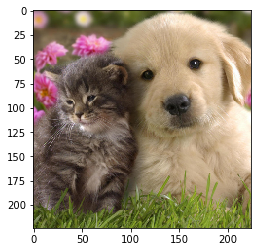

In [110]:
#sample image
img = plt.imread('data/Dog-and-Cat.jpg')
img = preprocess(img)

#deprocess and show, one line :)

plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

for i in range(10):
    print ' '.join(generate_caption(img,t=1.)[1:-1])
    

a #UNK# zebra laying in between eyes
a man is standing in a room with a teddy bear
the man is up at the cute house
a person is looking down at a person playing with a cat
a woman on a key board face a road
a person with a gray top and a t shirt
a little girl that is sitting down down the water playing in the sunlight
a black and white cat wearing its teeth
a woman with the nose bending over and looking at the camera
man eating a mug of his nose to owners while standing in a black wooden seat


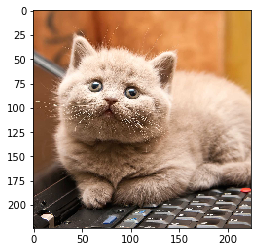

In [111]:
img = plt.imread('img/img1.jpg')
img = preprocess(img)

plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

for i in range(10):
    print ' '.join(generate_caption(img,t=1.)[1:-1])   

a short white photo of a various kittens
two black and white image of a building
two woman holding the ground on a bright green flowered eyes
a black and white photo of a brown brick wooden wall
pair of green and black and white objects in a room
a black side view of an old style in a room
a black and white photo of two small white parking meters in a building
a clock in the back of a block
an image of a photo of a very large clock
a grey white and black coffee and a persons legs


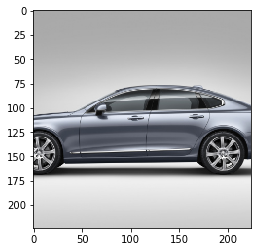

In [112]:
img = plt.imread('img/img2.jpg')
img = preprocess(img)

plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

for i in range(10):
    print ' '.join(generate_caption(img,t=1.)[1:-1])  

a man and a woman in a #UNK# jumping and goggles
woman on a wedding light right in the snow
a man standing on a skateboard on the posts
the brown and white image of a woman with a #UNK# and a jacket looking over the pole
the woman is reaching out of high birds
a man riding a green snowboard in the air
two people on the teams of people on their skis
the man is riding the finger over a hill
three young players during a group of people flying in their hands
a woman standing on top of a man with a surf board


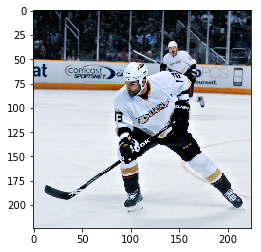

In [113]:
img = plt.imread('img/img3.jpg')
img = preprocess(img)

plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

for i in range(10):
    print ' '.join(generate_caption(img,t=1.)[1:-1])  

a boy standing in front of bleachers with a umbrella
the woman is riding around the top of a thing
on a fence on the beach with a baseball girl in the air
a batter flying up against a green wall
a woman standing next to a woman in a black and white photo is working on the toilet
a man with a suit is skateboarding in the park
a small child standing on a pitchers path below below people
the two people flying each other in the grass
a man catching a soccer ball on a lace court
a man holding a baseball bat is wearing a baseball uniform


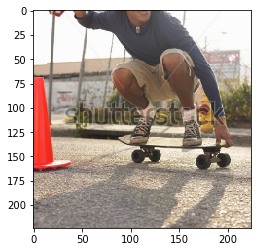

In [114]:
img = plt.imread('img/img4.jpg')
img = preprocess(img)

plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

for i in range(10):
    print ' '.join(generate_caption(img,t=1.)[1:-1])  

a few people and women sitting on a bench near parked grass
a close up of a person in a yellow and sheet reaching holding a kite
a woman cutting a blue flowers over a yellow rail
a person with a big green park in the background
#UNK# in a park on a green field
an ledge of a street with a kite standing on the dirt
a woman kicking a yellow kite behind a picnic table
blue and white photograph of a man that is jumping up
the woman is standing up outside the childs kite while he can between two park tables
a person in an outdoor jar looks up over a kite


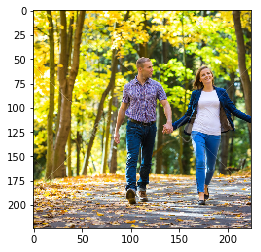

In [115]:
img = plt.imread('img/img5.jpg')
img = preprocess(img)

plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

for i in range(10):
    print ' '.join(generate_caption(img,t=1.)[1:-1])  

the black and brown black dog stands in the yard
a black bear on a dark area with a tree
two black bears eating together in a field
black black and white black black bear is about to eat a wall
black and white black colored black and black black animal
a black and white black looking over water hillside
brown white and black bear looking into the distance
two jackets in the black and black silver and black striped and black bear
black couple of black and black black black eating
woman children climbing up to the large black bear


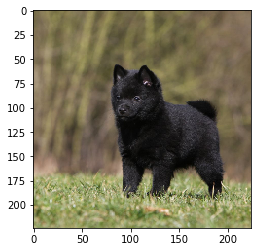

In [116]:
img = plt.imread('img/img6.jpg')
img = preprocess(img)

plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

for i in range(10):
    print ' '.join(generate_caption(img,t=1.)[1:-1])  

woman balancing #UNK# a large white animal
a man riding dirt on a yellow couch
people out around in the water and car is about to serve
big sort of a person on the back of a field
there is a young girl that is posing for a picture
the back of a multi colored photo of a person standing under a field
light banana unable to be kept near the flower
two white purple and black and white colored flowers
beach scene of a large cage in a suit garden
the large white building has #UNK# for it next to him


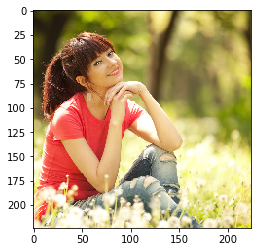

In [117]:
img = plt.imread('img/img7.jpg')
img = preprocess(img)

plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

for i in range(10):
    print ' '.join(generate_caption(img,t=1.)[1:-1])  

talking on a plate on top of the top of the hand
a man in a white shirt taking a photo with a tennis ball sits at a court
a man sits in front of a person holding a large green umbrella
dark place that is sitting on the skateboard that has been for the pitcher
a person that is jumping in the air with a racquet
a pitcher on the back of a park with a near the yard
a person standing on a stone surface with a bag
black and pink photo of a woman playing with a red frisbee
all color colorful men that are posing for a frisbee
the person has a pink disc in front of them


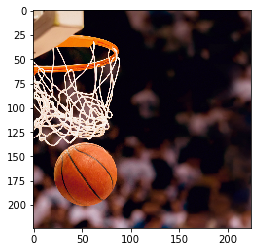

In [118]:
img = plt.imread('img/img8.jpg')
img = preprocess(img)

plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

for i in range(10):
    print ' '.join(generate_caption(img,t=1.)[1:-1])  

a group of people standing on a bridge next to a water cooking
a man jumping to the young woman on a bed
a couple of people standing on a crowded desk holding a long surfboard
a white passenger looking plane on a sandy beach
a man with glasses and a surfboard standing by a guy walking on the table
a group of water on a hard wood under a large group of people
a body of water and a propeller airplane
a woman pulling a frisbee as a bull horns
a white man standing in a black and white green and black and brown grey railroad yard
a woman coming down a green umbrellas with a purple passenger boat while them


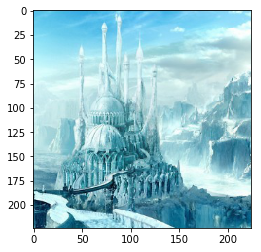

In [119]:
img = plt.imread('img/img9.jpg')
img = preprocess(img)

plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

for i in range(10):
    print ' '.join(generate_caption(img,t=1.)[1:-1])  

two birds on a sandy beach and on a lake
a little girl that is surfing on top of a white board
a person with a surf board in the air
the man is falling great a kite getting fast
two people on the stream playing with a kite
a large ridding of the boy on a surf board
a man that is in the water carrying an umbrella
a woman walking on a late along #UNK# holding a surfboard
two people in the water next to a dog in the ocean
a man in the ocean holding a child in the water


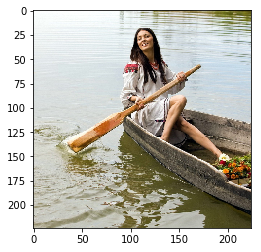

In [120]:
img = plt.imread('img/img10.jpg')
img = preprocess(img)

plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

for i in range(10):
    print ' '.join(generate_caption(img,t=1.)[1:-1])  

person on a baseball field patiently on the men
a person in uniform on a court
a man in a blue and white uniform at a baseball game
an one woman is enjoying the outside of a major net
the woman is playing a game of tennis
a man and a woman are holding an arrow
a person jumping to a ball in front of a shake legs
a woman throws the top #UNK# on a tennis court
a man showing a soccer ball as he stands next to a white building
a man skateboarding in a cage with a bicyclist


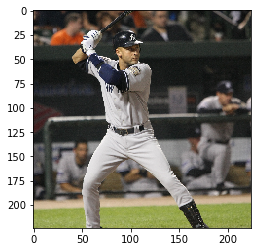

In [121]:
img = plt.imread('img/img11.jpg')
img = preprocess(img)

plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

for i in range(10):
    print ' '.join(generate_caption(img,t=1.)[1:-1])  

a person is playing the tennis ball in the air
a lady in her #UNK# stands on the edge of a building
a woman and a woman posing for a picture
a person on a skate board doing a trick
a man in a white shirt and white and black shorts hanging off of a run skating
a woman sitting on a carrying a paddle board
a woman on a skateboard that is underneath a sheet
man jumping into the air while yellow wait prepares to get off a skateboard
a young man on a skateboard and a spray candle
a guy jumping over the mans plate as he dragging a skateboard


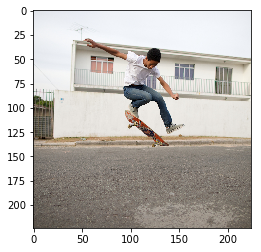

In [122]:
img = plt.imread('img/img12.jpg')
img = preprocess(img)

plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

for i in range(10):
    print ' '.join(generate_caption(img,t=1.)[1:-1])  

two people who are eating something off a face
the small bear swimming in the middle of the woods
three gray cats standing outside on a wood surface
a woman and pieces of a black bird on a rock stump
person three little girl kicking the ride on the bicycles
the baby baby stretches a hood of his tongue
a black bear eating on a sunny day
a baby chasing its in the distance with a bear roosts and his mouth on the ground
two teddy bears walking around and habitat inside an enclosure
the baby in the legs of a brown and white head and bear resting in the leaf with trees


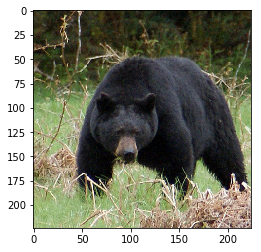

In [123]:
img = plt.imread('img/img13.jpg')
img = preprocess(img)

plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

for i in range(10):
    print ' '.join(generate_caption(img,t=1.)[1:-1])  

a woman wearing a red coat on a bicycle in a city
a man standing in the palm an airplane with lens cell phones on the ground
several people that are windsurfing on the sidewalk
a man standing near back males on a sidewalk wearing sunglasses holding up a cell phone
two women on the top of a #UNK#
male and white photograph of people playing a street
a lady standing outside having an old photograph of a man on a skateboard
a man holding the hand #UNK# showing a model of a camera
a man is holding a red and white and silver sweater
two people walking through a zoo holding wine and sunglasses


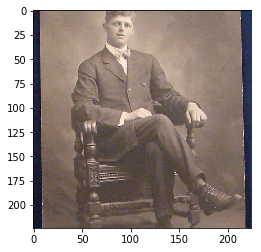

In [124]:
img = plt.imread('img/img14.jpg')
img = preprocess(img)

plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

for i in range(10):
    print ' '.join(generate_caption(img,t=1.)[1:-1])  

a brown white dog and a black goat and a brown #UNK#
two cattle in a field of white cow
a man that is relaxing on a bench alone
two black and white dogs standing on a field with a dog
woman in black and black and white cows
two dogs on a field holding skis on a leash
the large cow with his head under a chain link grass
a black and white dog in a green field
a child on the back of a owner
the baby of a brown and white dog playing with the ocean in ground


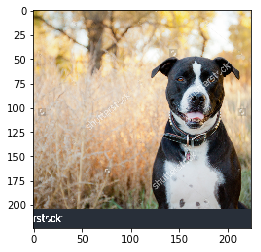

In [125]:
img = plt.imread('img/img15.jpg')
img = preprocess(img)

plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

for i in range(10):
    print ' '.join(generate_caption(img,t=1.)[1:-1])  

man standing up holding arms of balls and sunglasses
a man standing on a tennis court hitting a ball
the woman on the tennis court returning the tennis ball
a man on a court with his hand while playing tennis
a man in front of a tennis two sexy girl balances on
arm outfielder tennis player tossing a ball while his spectators watch
a woman reaching for her #UNK# #UNK# a white frisbee
a woman holding a tennis racket on a court
the woman is flying a racket so the young kid
a man on a tennis court about to return a tennis ball


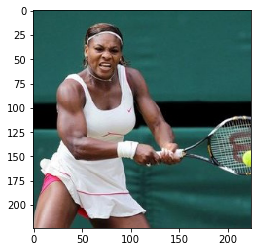

In [126]:
img = plt.imread('img/img16.jpg')
img = preprocess(img)

plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

for i in range(10):
    print ' '.join(generate_caption(img,t=1.)[1:-1])  

a man sitting beside a barrier going in
two people in a train station over a train car
the large deck gentleman getting red train cars
a train on a train track at the day
an older crossing in a city city with a red traffic light
there at the end of a busy street
an old white and blue parking street with a bright red building at itself
the base of the small berry house at a train station
there is a blue and red image of a train on a railroad platform
a woman on a blue dress at the street checks at a microphone to pass his heads


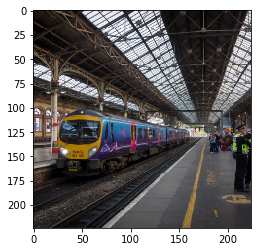

In [127]:
img = plt.imread('img/img17.jpg')
img = preprocess(img)

plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

for i in range(10):
    print ' '.join(generate_caption(img,t=1.)[1:-1])  

woman with two glasses is on the side walk blowing out the camera
a woman posing for a picture while wearing a hat
there is a woman dressed in a childs purple shirt and stuff is standing on a bed with some men tennis
woman looking at herself with a woman dark
a girl in a stall looking on a and talking on the phone
woman with blue and white hair against a black shirt
a woman with a blue her shirt holding a pink black and white bag
two young woman smiling for a bite take out five music
a woman in an airport holding a close up up on her paper
woman in black and black hair and a white and white photo smiling facing her face


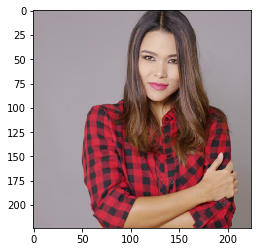

In [128]:
img = plt.imread('img/img18.jpg')
img = preprocess(img)

plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

for i in range(10):
    print ' '.join(generate_caption(img,t=1.)[1:-1])  

surfer is on a wave of the shore of water
man in black jacket carrying water wave as he the flies legs with waves toward the camera
a woman walking with some kind of front of a sail boat in the ocean
a man on a bird with a symbol on his back
a woman in to a little child watch the ocean
an #UNK# of the water is in the sky
man in their wheel flies paddle on beach
hill as two men kiteboarding out of ocean with waves around
the person on a steep surf board is in the water
a few action of water that is in the water


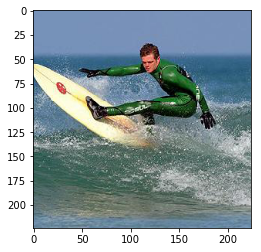

In [129]:
img = plt.imread('img/img19.jpg')
img = preprocess(img)

plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

for i in range(10):
    print ' '.join(generate_caption(img,t=1.)[1:-1])  

a man is flipping off his motorcycle on the time
the person is on the bench in the open
there is a photo of some people on a skate board
large park distant clock line for sale with its side
the person is dressed as the boy poses for the camera
three green light on a bike chained to race
a group of people behind the base of a motorcycle
street with a large white bench with two remotes
a photo of a man on a bike coming across a runway
a woman standing on a surface with a dog


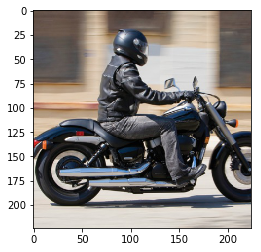

In [130]:
img = plt.imread('img/img20.jpg')
img = preprocess(img)

plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

for i in range(10):
    print ' '.join(generate_caption(img,t=1.)[1:-1])  